In [1]:
import numpy as np
import tensorflow as tf
import torch
from scipy.signal import welch
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# === FIX SEEDS for reproducibility ===
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# === Load models ===
generator = tf.keras.models.load_model("saved_models/generator_final.keras")
posterior = torch.load("saved_models/trained_sbi_posterior.pt")

# === Lorentzian fit for Q factor ===
def lorentzian(f, A, f0, gamma):
    return A / (1 + ((f - f0) / gamma) ** 2)

def compute_lorentzian_q(series, fs=1.0, f_window=(0.01, 0.5)):
    try:
        f, Pxx = welch(series.squeeze(), fs=fs, nperseg=256)
        mask = (f > f_window[0]) & (f < f_window[1])
        f_peak = f[mask]
        Pxx_peak = Pxx[mask]
        p0 = [np.max(Pxx_peak), f_peak[np.argmax(Pxx_peak)], 0.01]
        popt, _ = curve_fit(lorentzian, f_peak, Pxx_peak, p0=p0, maxfev=5000)
        A, f0, gamma = popt
        if gamma <= 0 or f0 <= 0:
            return 0.0
        return f0 / gamma
    except:
        return 0.0

# === QPO detection scoring ===
def detect_qpo(lightcurve):
    f, Pxx = welch(lightcurve.squeeze(), fs=1.0, nperseg=256)
    x_obs = torch.tensor(Pxx, dtype=torch.float32)
    samples = posterior.sample((500,), x=x_obs, show_progress_bars=False)
    fc_samples = samples[:, 0].numpy()
    amp_samples = samples[:, 1].numpy()
    fc_std = fc_samples.std()
    amp_mean = amp_samples.mean()
    Q = compute_lorentzian_q(lightcurve)
    score = np.log1p(Q) + amp_mean - fc_std
    return score

# === GAN generation ===
def generate_lightcurves(n_qpo=50, n_nonqpo=50):
    latent_dim = 100
    lightcurves, labels = [], []
    for is_qpo in [1.0, 0.0]:
        for _ in range(n_qpo if is_qpo else n_nonqpo):
            z = np.random.normal(0, 1, size=(1, latent_dim))
            fc = np.random.uniform(0.1, 0.5)
            amp = np.random.uniform(0.1, 1)
            cond = np.array([[fc, amp, is_qpo]])
            signal = generator.predict([z, cond], verbose=0).squeeze()
            lightcurves.append(signal)
            labels.append(int(is_qpo))
    return np.array(lightcurves), np.array(labels)

# === One run of threshold sweep ===
def threshold_sweep(scores, labels):
    thresholds = np.linspace(0, 1.5, 100)
    f1_curve = []
    for t in thresholds:
        preds = (np.array(scores) > t).astype(int)
        tp = np.sum((preds == 1) & (labels == 1))
        fp = np.sum((preds == 1) & (labels == 0))
        fn = np.sum((preds == 0) & (labels == 1))
        p = tp / (tp + fp + 1e-6)
        r = tp / (tp + fn + 1e-6)
        f1 = 2 * p * r / (p + r + 1e-6)
        f1_curve.append(f1)
    best_idx = np.argmax(f1_curve)
    return thresholds[best_idx], f1_curve, thresholds

/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_69249/2878141995.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load("saved_models/trained

In [2]:
# === Run multiple experiments ===
n_runs = 100
best_thresholds = []
all_f1_curves = []

for i in range(n_runs):
    lightcurves, labels = generate_lightcurves()
    scores = [detect_qpo(lc) for lc in lightcurves]
    best_thres, f1_curve, thresholds = threshold_sweep(scores, labels)
    best_thresholds.append(best_thres)
    all_f1_curves.append(f1_curve)
    print(f"Run {i+1}: Best Threshold = {best_thres:.3f}")




Run 1: Best Threshold = 0.394
Run 2: Best Threshold = 0.000
Run 3: Best Threshold = 0.379
Run 4: Best Threshold = 0.379
Run 5: Best Threshold = 0.000
Run 6: Best Threshold = 0.394
Run 7: Best Threshold = 0.379
Run 8: Best Threshold = 0.455
Run 9: Best Threshold = 0.379
Run 10: Best Threshold = 0.348
Run 11: Best Threshold = 0.379
Run 12: Best Threshold = 0.439
Run 13: Best Threshold = 0.424
Run 14: Best Threshold = 0.394
Run 15: Best Threshold = 0.455
Run 16: Best Threshold = 0.379
Run 17: Best Threshold = 0.394
Run 18: Best Threshold = 0.000
Run 19: Best Threshold = 0.348
Run 20: Best Threshold = 0.439
Run 21: Best Threshold = 0.409
Run 22: Best Threshold = 0.439
Run 23: Best Threshold = 0.409
Run 24: Best Threshold = 0.424
Run 25: Best Threshold = 0.364
Run 26: Best Threshold = 0.000
Run 27: Best Threshold = 0.439
Run 28: Best Threshold = 0.348
Run 29: Best Threshold = 0.000
Run 30: Best Threshold = 0.000
Run 31: Best Threshold = 0.394
Run 32: Best Threshold = 0.439
Run 33: Best Thre


Filtered Threshold Statistics:
Mean Best Threshold:   0.395
Std Deviation:         0.030


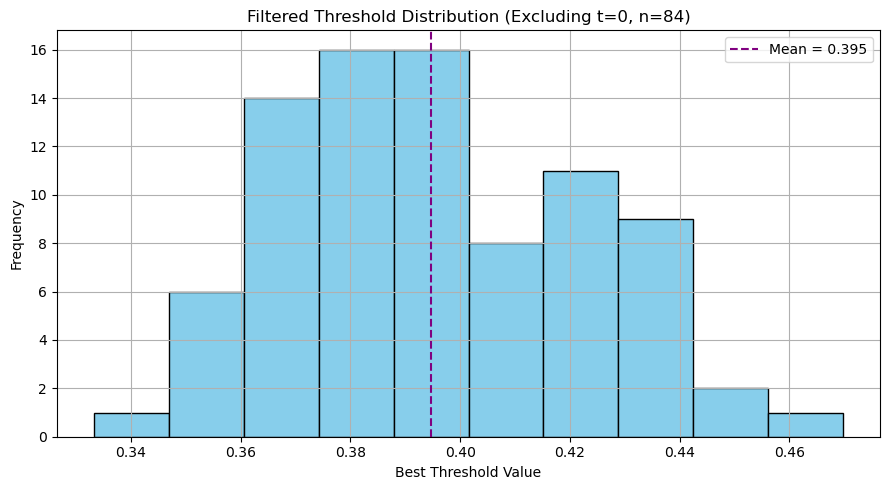

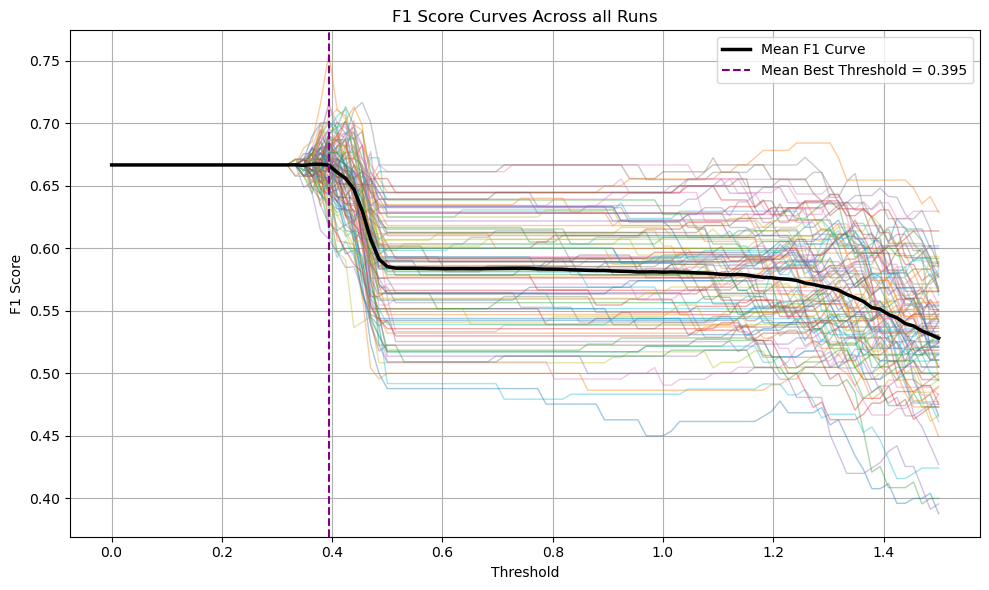

In [4]:
# === Filter out degenerate thresholds (t=0) ===
filtered_thresholds = [t for t in best_thresholds if t > 0.0]
mean_threshold = np.mean(filtered_thresholds)
std_threshold = np.std(filtered_thresholds)
n_removed = len(best_thresholds) - len(filtered_thresholds)

# === Summary ===
print("\nFiltered Threshold Statistics:")
# print(f"Valid Runs:            {len(filtered_thresholds)} / {n_runs}")
# print(f"Removed (t = 0):       {n_removed} runs")
print(f"Mean Best Threshold:   {mean_threshold:.3f}")
print(f"Std Deviation:         {std_threshold:.3f}")


# === Plot histogram of filtered thresholds ===
plt.figure(figsize=(9, 5))
plt.hist(filtered_thresholds, bins=10, color='skyblue', edgecolor='black')
plt.axvline(mean_threshold, color='purple', linestyle='--', label=f"Mean = {mean_threshold:.3f}")
plt.title(f"Filtered Threshold Distribution (Excluding t=0, n={len(filtered_thresholds)})")
plt.xlabel("Best Threshold Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot all F1 curves ===
plt.figure(figsize=(10, 6))
for f1 in all_f1_curves:
    plt.plot(thresholds, f1, alpha=0.4, lw=1)
plt.plot(thresholds, np.mean(all_f1_curves, axis=0), color='black', lw=2.5, label='Mean F1 Curve')
plt.axvline(mean_threshold, color='purple', linestyle='--', label=f"Mean Best Threshold = {mean_threshold:.3f}")
plt.title("F1 Score Curves Across all Runs")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()